# Basic AB

In [1]:
import pandas as pd 
import numpy as np 
from scipy import stats
import plotly.express as px
import seaborn as sb
import plotly.figure_factory as ff
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.stattools as sss
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Работа основана на статье 
Muralidharan, Karthik, Abhijeet
Singh, and Alejandro J. Ganimian. 2019. "Disrupting Education? Experimental Evidence on
Technology-Aided Instruction in India."American Economic Review, 109 (4): 1426-60.DOI:
10.1257/aer.20171112

Оценка влияния бесплатных доп курсов на успеваемость индийских учеников 

In [2]:
# Загружаем данные
df_long = pd.read_stata('ms_blel_jpal_long.dta')
df_wide = pd.read_stata('ms_blel_jpal_wide.dta')

# Балансовая таблица

### Далее идет большая функция по расчетам балансовой таблицы

In [3]:
variables = ['st_female1', 
             'st_age1', 
             'ses_index', 
             'd_sch_grade4',
             'd_sch_grade5',
             'd_sch_grade6',
             'd_sch_grade7',
             'd_sch_grade8',
              'd_sch_grade9',
              'any_tuition',
              'st_tui_other',
              'st_tui_math',
              'st_tui_hindi'
             ]

def calculate_balance_table(df, group_var, variables):
    balance_table = []

    for var in variables:
        mean_treat = df[df[group_var] == 1][var].mean()
        std_treat = df[df[group_var] == 1][var].std()
        std_control = df[df[group_var] == 0][var].std()
        mean_control = df[df[group_var] == 0][var].mean()
        diff = mean_treat - mean_control

        std_error = stats.sem(df[df[group_var] == 1][var].dropna()) + stats.sem(df[df[group_var] == 0][var].dropna())

        balance_table.append({
            'Variable': var,
            'Mean (Treatment)': mean_treat,
            'Mean (Control)': mean_control,
            'Std (Treatment)':std_treat,
            'Std (Control)':std_control,
            'Difference': diff,
            'Std. Error': std_error,
            'Observations (Treatment)': df[df[group_var] == 1][var].count(),
            'Observations (Control)': df[df[group_var] == 0][var].count()
        })
    balance_table = pd.DataFrame(balance_table)
    for ind, row in balance_table.iterrows():
        sample1 = df[df['treat']==1][row['Variable']].dropna().astype(int).to_list()
        sample2 = df[df['treat']==0][row['Variable']].dropna().astype(int).to_list()
        if len(df[row['Variable']].dropna().unique()) == 2:
            count_1_sample1 = sample1.count(1)
            count_0_sample1 = sample1.count(0)
            count_1_sample2 = sample2.count(1)
            count_0_sample2 = sample2.count(0)
            table = [[count_1_sample1, count_0_sample1],
                    [count_1_sample2, count_0_sample2]]
            t_stat, p_value = stats.fisher_exact(table)
            p_value = float(p_value)
            t_stat = float(t_stat)
            balance_table.at[ind,'p-val'] = p_value
            balance_table.at[ind,'stat'] = t_stat
        else:
            t_stat,p_value = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')
            p_value = float(p_value)
            t_stat = float(t_stat)
            balance_table.at[ind,'p-val'] = p_value
            balance_table.at[ind,'stat'] = t_stat
    return balance_table

balance_table = calculate_balance_table(df_long, 'treat', variables)

In [4]:
balance_table

,Variable,Mean (Treatment),Mean (Control),Std (Treatment),Std (Control),Difference,Std. Error,Observations (Treatment),Observations (Control),p-val,stat
0,st_female1,0.7672,0.7595,0.4230,0.4277,0.0077,0.0354,580,578,0.7823,1.0437
1,st_age1,12.6455,12.3894,1.5669,1.5176,0.2561,0.1488,426,434,0.0247,100459.5000
2,ses_index,-0.0944,0.0319,1.6702,1.6825,-0.1263,0.1393,580,578,0.0071,153108.0000
3,d_sch_grade4,0.0071,0.0106,0.0841,0.1023,-0.0035,0.0078,563,568,0.7528,0.6702
4,d_sch_grade5,0.0124,0.0211,0.1109,0.1439,-0.0087,0.0107,563,568,0.3553,0.5833
5,d_sch_grade6,0.2735,0.3028,0.4462,0.4599,-0.0293,0.0381,563,568,0.2937,0.8669
6,d_sch_grade7,0.2611,0.2588,0.4396,0.4384,0.0023,0.0369,563,568,0.9460,1.0120
7,d_sch_grade8,0.3020,0.2835,0.4595,0.4511,0.0185,0.0383,563,568,0.5137,1.0935
8,d_sch_grade9,0.1439,0.1232,0.3513,0.3290,0.0206,0.0286,563,568,0.3364,1.1956
9,any_tuition,0.8128,0.8243,0.3904,0.3809,-0.0115,0.0321,577,575,0.6466,0.9253


In [5]:
# Проведем многомерный ANOVA тест
from statsmodels.multivariate.manova import MANOVA
manova = MANOVA.from_formula(f"{'+ '.join(x for x in balance_table['Variable'].to_list())} ~ treat", data=df_long)
print(manova.mv_test())

                                   Multivariate linear model
                                                                                               
-----------------------------------------------------------------------------------------------
       Intercept                Value           Num DF  Den DF          F Value          Pr > F
-----------------------------------------------------------------------------------------------
          Wilks' lambda                -0.0000 13.0000 813.0000 -140824096040469792.0000 1.0000
         Pillai's trace                 1.0000 13.0000 813.0000 -140824096040469808.0000 1.0000
 Hotelling-Lawley trace -2251799813685249.0000 13.0000 813.0000 -140824096040469808.0000 1.0000
    Roy's greatest root -2251799813685249.0000 13.0000 813.0000 -140824096040469808.0000 1.0000
-----------------------------------------------------------------------------------------------
                                                                           

In [7]:
# Тест Хоттелинга
from pingouin import multivariate_ttest
X = df_long[df_long['treat'] == 1][variables]
Y = df_long[df_long['treat'] == 0][variables]
multivariate_ttest(X, Y)

,T2,F,df1,df2,pval
hotelling,15.6468,1.1861,13,813,0.2844


# Оценка эффекта доп курсов

In [7]:
df_wide.describe()

,st_tui_math1,st_tui_hindi1,st_tui_other1,tot_hindi1,tot_math1,per_math1,per_hindi1,m_theta_eap1,m_theta_mle1,h_theta_eap1,...,st_grade1,treat,strata,ses_index,d_sch_grade4,d_sch_grade5,d_sch_grade6,d_sch_grade7,d_sch_grade8,d_sch_grade9
count,619.0000,619.0000,619.0000,619.0000,619.0000,619.0000,619.0000,617.0000,617.0000,617.0000,...,604.0000,619.0000,619.0000,619.0000,604.0000,604.0000,604.0000,604.0000,604.0000,604.0000
mean,0.4653,0.3683,0.3958,12.8352,11.1212,0.3177,0.4278,-0.0000,0.0000,0.0000,...,7.2301,0.5073,11.2423,-0.0000,0.0083,0.0166,0.2831,0.2599,0.2930,0.1391
std,0.4992,0.4827,0.4894,4.9452,3.9042,0.1115,0.1648,1.0000,1.0000,1.0000,...,1.1056,0.5004,5.5680,1.7001,0.0907,0.1277,0.4509,0.4390,0.4555,0.3463
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-2.4276,-3.7129,-2.5760,...,4.0000,0.0000,1.0000,-5.6306,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,9.0000,9.0000,0.2571,0.3000,-0.5851,-0.3910,-0.6553,...,6.0000,0.0000,5.0000,-1.2781,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,13.0000,11.0000,0.3143,0.4333,0.1152,0.1481,-0.0074,...,7.0000,1.0000,13.0000,0.1241,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,1.0000,1.0000,1.0000,16.0000,14.0000,0.4000,0.5333,0.6025,0.5786,0.6658,...,8.0000,1.0000,16.0000,1.3892,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000
max,1.0000,1.0000,1.0000,27.0000,26.0000,0.7429,0.9000,2.4425,1.8888,3.1051,...,9.0000,1.0000,19.0000,4.7761,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [9]:
# Тест Уэлча
t_stat_math, p_value_math = stats.ttest_ind(
    df_wide[df_wide['treat'] == 1]['tot_math2'].dropna(),
    df_wide[df_wide['treat'] == 0]['tot_math2'].dropna(),
    equal_var=False
)

t_stat_hindi, p_value_hindi = stats.ttest_ind(
    df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna(),
    df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna(),
    equal_var=False
)
hindi_mean = df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna().mean() - df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna().mean()
math_mean = df_wide[df_wide['treat'] == 1]['tot_math2'].dropna().mean() - df_wide[df_wide['treat'] == 0]['tot_math2'].dropna().mean()
pd.DataFrame({'Subject': ['Math', 'Hindi'],
              'Разница средних':[math_mean,hindi_mean ],
    't_stat': [t_stat_math, t_stat_hindi],
    'p_value': [p_value_math, p_value_hindi]})

,Subject,Разница средних,t_stat,p_value
0,Math,2.6915,5.3701,0.0000
1,Hindi,1.9557,4.0196,0.0001


In [10]:
pd.DataFrame({'Subject': ['Math', 'Hindi'],
              'Разница средних':[math_mean,hindi_mean ],
    't_stat': [t_stat_math, t_stat_hindi],
    'p_value': [p_value_math, p_value_hindi]})

,Subject,Разница средних,t_stat,p_value
0,Math,2.6915,5.3701,0.0000
1,Hindi,1.9557,4.0196,0.0001


In [69]:
# Тест Манна-Уитни
t_stat_math, p_value_math = stats.mannwhitneyu(
    df_wide[df_wide['treat'] == 1]['tot_math2'].dropna(),
    df_wide[df_wide['treat'] == 0]['tot_math2'].dropna(),
    alternative='two-sided'
)

t_stat_hindi, p_value_hindi = stats.mannwhitneyu(
    df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna(),
    df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna(),
    alternative='two-sided'
)
hindi_mean = df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna().mean() - df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna().mean()
math_mean = df_wide[df_wide['treat'] == 1]['tot_math2'].dropna().mean() - df_wide[df_wide['treat'] == 0]['tot_math2'].dropna().mean()
pd.DataFrame({'Subject': ['Math', 'Hindi'],
    'Разница средних':[math_mean,hindi_mean ],
    't_stat': [t_stat_math, t_stat_hindi],
    'p_value': [p_value_math, p_value_hindi]})

,Subject,Разница средних,t_stat,p_value
0,Math,2.6915,46034.5000,0.0000
1,Hindi,1.9557,43204.5000,0.0001


In [11]:
pd.DataFrame({'Subject': ['Math', 'Hindi'],
    'Разница средних':[math_mean,hindi_mean ],
    't_stat': [t_stat_math, t_stat_hindi],
    'p_value': [p_value_math, p_value_hindi]})

,Subject,Разница средних,t_stat,p_value
0,Math,2.6915,5.3701,0.0000
1,Hindi,1.9557,4.0196,0.0001


In [84]:
ff.create_distplot([df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna(),
                    np.random.normal(df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna().mean(),
                                     df_wide[df_wide['treat'] == 1]['tot_hindi2'].dropna().std(),len(df_wide[df_wide['treat'] == 1]))], 
                                     ['Балл по хинди','Нормальное распределение'], show_hist=False)

In [87]:
ff.create_distplot([df_wide['tot_hindi2'].dropna(),
                    np.random.normal(df_wide['tot_hindi2'].dropna().mean(),
                                     df_wide['tot_hindi2'].dropna().std(),len(df_wide))], 
                                     ['Балл по хинди','Нормальное распределение'], show_hist=False)

In [88]:
ff.create_distplot([df_wide['tot_math2'].dropna(),
                    np.random.normal(df_wide['tot_math2'].dropna().mean(),
                                     df_wide['tot_math2'].dropna().std(),len(df_wide))], 
                                     ['Балл по хинди','Нормальное распределение'], show_hist=False)

In [77]:
ff.create_distplot([df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna(),
                    np.random.normal(df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna().mean(),
                                     df_wide[df_wide['treat'] == 0]['tot_hindi2'].dropna().std(),len(df_wide[df_wide['treat'] == 0]))], 
                                     ['Балл по хинди','Нормальное распределение'], show_hist=False)

In [13]:
ff.create_distplot([df_wide[df_wide['treat'] == 1]['tot_math2'].dropna(),
                    np.random.normal(df_wide[df_wide['treat'] == 1]['tot_math2'].dropna().mean(),
                                     df_wide[df_wide['treat'] == 1]['tot_math2'].dropna().std(),len(df_wide[df_wide['treat'] == 1]))], 
                                     ['Балл по математике','Нормальное распределение'], show_hist=False)

In [89]:
ff.create_distplot([df_wide[df_wide['treat'] == 0]['tot_math2'].dropna(),
                    np.random.normal(df_wide[df_wide['treat'] == 0]['tot_math2'].dropna().mean(),
                                     df_wide[df_wide['treat'] == 0]['tot_math2'].dropna().std(),len(df_wide[df_wide['treat'] == 0]))], 
                                     ['Балл по математике','Нормальное распределение'], show_hist=False)

# Бутстрап оценка

In [90]:
# Функция расчета среднего эффекта, просто чтобы не писать много раз
def mean_effect(data, treatment_var, score_var):
    mean_treat = data[data[treatment_var] == 1][score_var].mean()
    mean_control = data[data[treatment_var] == 0][score_var].mean()
    return mean_treat - mean_control

# Функция по созданию бутсрап выборки и расчета интервалов 
def bootstrap_self(data, treatment_var, score_var, n_bootstrap=5000, confidence_level=0.95):
    bootstrap_estimates = []
    bootstrap_estimates_hall = []
    bootstrap_estimates_t_proc = []
    for _ in range(n_bootstrap):
        bootstrap_sample = data.sample(frac=1, replace=True)
        effect = mean_effect(bootstrap_sample, treatment_var, score_var)
        eff_hall = effect - mean_effect(data,treatment_var, score_var) 
        eff_t_proc = (effect - mean_effect(data,treatment_var, score_var)) / bootstrap_sample[score_var].std()
        bootstrap_estimates_t_proc.append(eff_t_proc)
        bootstrap_estimates.append(effect)
        bootstrap_estimates_hall.append(eff_hall)
    
    effect = np.mean(bootstrap_estimates)
    mean_eff = mean_effect(data, treatment_var, score_var)
    lower_bound = np.percentile(bootstrap_estimates, (1 - confidence_level) / 2 * 100) 
    upper_bound = np.percentile(bootstrap_estimates, (1 + confidence_level) / 2 * 100) 
    adj_lower_bound = mean_eff - np.percentile(bootstrap_estimates_hall, (1 + confidence_level) / 2 * 100) 
    adj_upper_bound = mean_eff - np.percentile(bootstrap_estimates_hall, (1 - confidence_level) / 2 * 100) 
    t_proc_upper = mean_eff - data[score_var].std() * np.percentile(bootstrap_estimates_t_proc, (1 - confidence_level) / 2 * 100)
    t_proc_lower = mean_eff - data[score_var].std() * np.percentile(bootstrap_estimates_t_proc, (1 + confidence_level) / 2 * 100)
    
    return effect,(lower_bound, upper_bound), (adj_lower_bound, adj_upper_bound), (t_proc_lower,t_proc_upper)

mean_effect_hindi, ci_hindi,ci_hindi_adj, t_proc_hindi = bootstrap_self(df_wide, 'treat', 'tot_hindi2')
mean_effect_math, ci_math,ci_math_adj, t_proc_math = bootstrap_self(df_wide, 'treat', 'tot_math2')


results = {
    'Предмет': ['Math', 'Hindi'],
    'Mean Effect': [mean_effect_math, mean_effect_hindi],
    'Нижний доверительный интервал дикий': [ci_math[0], ci_hindi[0]],
    'Верхний доверительный интервал дикий': [ci_math[1], ci_hindi[1]],
    'Нижний доверительный интервал Холла': [ci_math_adj[0], ci_hindi_adj[0]],
    'Верхний доверительный интервал Холла': [ci_math_adj[1], ci_hindi_adj[1]],
    'Нижний t-процентильный ': [t_proc_math[0],t_proc_hindi[0]],
    'Верхний t-процентильный ': [t_proc_math[1],t_proc_hindi[1]],
}

results = pd.DataFrame(results)
results

,Предмет,Mean Effect,Нижний доверительный интервал дикий,Верхний доверительный интервал дикий,Нижний доверительный интервал Холла,Верхний доверительный интервал Холла,Нижний t-процентильный,Верхний t-процентильный
0,Math,2.6979,1.7248,3.6771,1.7059,3.6583,1.7145,3.6653
1,Hindi,1.9519,1.0159,2.8781,1.0332,2.8955,1.0437,2.9010


#  МНК

In [118]:
m02 = smf.ols(formula='tot_hindi2~ treat', data=df_wide).fit()
m03 = smf.ols(formula='tot_math2~ treat', data=df_wide).fit()
display(f'коэфициент для treat для Хинди {float(m02.params["treat"])}')
display(f'коэфициент для treat для Математики {float(m03.params["treat"])}')

'коэфициент для treat для Хинди 1.9556583767110056'

'коэфициент для treat для Математики 2.691536533641792'

# ЛАССО

In [129]:
m02 = smf.ols(formula='tot_hindi2~ treat', data=df_wide).fit_regularized(method='sqrt_lasso', alpha=1)
m03 = smf.ols(formula='tot_math2~ treat', data=df_wide).fit_regularized(method='sqrt_lasso', alpha=1 )
display(f'коэфициент для treat для Хинди {float(m02.params["treat"])}')
display(f'коэфициент для treat для Математики {float(m03.params["treat"])}')

'коэфициент для treat для Хинди 1.9317441279886045'

'коэфициент для treat для Математики 2.666928320664009'

# Учет гетерогенности

In [133]:
df_long.columns

Index(['st_id', 'round', 'ms_center1', 'st_age1', 'st_female1', 'st_grade1',
       'treat', 'strata', 'st_tui_math', 'st_tui_hindi', 'st_tui_other',
       'st_tui_math_hrs', 'ts_grade', 'tot_hindi', 'tot_math', 'per_math',
       'per_hindi', 'm_theta_eap', 'm_theta_mle', 'h_theta_eap', 'h_theta_mle',
       'ses_index', 'd_sch_grade4', 'd_sch_grade5', 'd_sch_grade6',
       'd_sch_grade7', 'd_sch_grade8', 'd_sch_grade9', 'any_tuition',
       'quint_math1', 'quint_hindi1', 'terc_math1', 'terc_hindi1', 'control',
       'r2', 'in_r2'],
      dtype='object')

In [184]:
m_hindi = smf.ols('tot_hindi2 ~ treat * (ses_index + st_age1+ h_theta_eap1  + st_tui_hindi1 )', data=df_wide).fit()

# Печатаем результаты моделей

m_hindi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tot_hindi2   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     53.92
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           4.63e-63
Time:                        01:55:38   Log-Likelihood:                -1103.7
No. Observations:                 399   AIC:                             2227.
Df Residuals:                     389   BIC:                             2267.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.1152      2.369      5.535      0.000       8.457      17.774
treat                  10.3069      3.333      3.092      0.002       3.753      16.860
ses_index               0.3031      0.173      1.748      0.081      -0.038       0.644
st_age1                 0.2202      0.185      1.192      0.234      -0.143       0.583
h_theta_eap1            4.1671      0.310     13.446      0.000       3.558       4.776
st_tui_hindi1          -0.9850      0.578     -1.703      0.089      -2.122       0.152
treat:ses_index         0.4199      0.246      1.707      0.089      -0.064       0.904
treat:st_age1          -0.6455      0.260     -2.480      0.014      -1.157      -0.134
treat:h_theta_eap1     -0.4417      0.443     -0.996      0.320      -1.313       0.430
treat:st_tui_hindi1    -0.0884      0.814     -0.109      0.914      -1.689       1.512
==============================================================================
Omnibus:                        9.871   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.207
Skew:                          -0.283   Prob(JB):                      0.00369
Kurtosis:                       3.594   Cond. No.                         285.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
m_math = smf.ols('tot_math2 ~ treat * (st_age1  + m_theta_eap1 )', data=df_wide).fit()
m_math.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              tot_math2   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     54.89
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           3.93e-43
Time:                        01:55:48   Log-Likelihood:                -1158.2
No. Observations:                 397   AIC:                             2328.
Df Residuals:                     391   BIC:                             2352.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.3882      2.600      4.765      0.000       7.277      17.500
treat                 10.7549      3.746      2.871      0.004       3.389      18.120
st_age1                0.2570      0.208      1.234      0.218      -0.152       0.667
m_theta_eap1           3.2165      0.319     10.076      0.000       2.589       3.844
treat:st_age1         -0.6226      0.297     -2.098      0.037      -1.206      -0.039
treat:m_theta_eap1     0.4935      0.459      1.076      0.283      -0.408       1.395
==============================================================================
Omnibus:                        4.478   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                4.240
Skew:                          -0.243   Prob(JB):                        0.120
Kurtosis:                       3.145   Cond. No.                         273.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Casual Random forest

In [3]:
from econml.dml import CausalForestDML

In [12]:
X=['ses_index', 'st_age1', 'h_theta_eap1', 'st_tui_hindi1']
data = df_wide[X + ['tot_math2','treat']].copy().dropna()
y=data['tot_math2']
X=data[X]
Y=y
T = data['treat']
W=None
causal_forest= CausalForestDML(criterion='het', n_estimators=10000,       
                      min_samples_leaf=10, 
                      max_depth=4, 
                      cv=10, 
                       min_samples_split=50)

In [13]:
causal_forest.fit(Y, T, X=X, W=W)

In [14]:
print(causal_forest.const_marginal_effect(X).mean())

2.22851324409329


In [15]:
causal_forest.const_marginal_ate_inference(X)

In [16]:
features=[]
features=np.array(list(zip(causal_forest.cate_feature_names(), causal_forest.feature_importances_.tolist())))
features=pd.DataFrame(features).rename(columns={0: 'covariate', 1: 'importance'}).round(3)

In [20]:
import shap

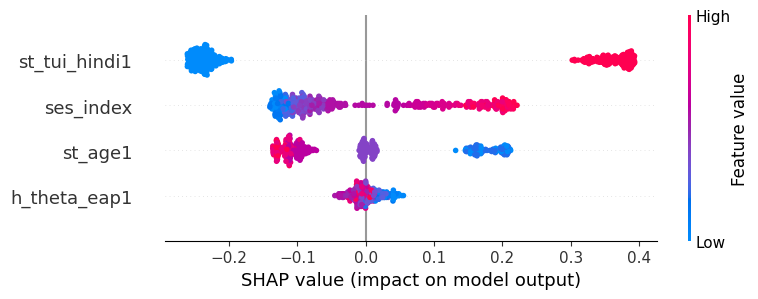

In [31]:
shap.summary_plot(shap_values['tot_math2']['treat'])